Silico simulated data

In [21]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Parameters
num_participants = 30
days_per_participant = 1  # Simulate one day per participant
readings_per_day = 288  # 5-minute intervals in 24 hours

# Define participant categories
categories = ['Normal', 'Pre-diabetic', 'Diabetic']
participants_per_category = num_participants // len(categories)

# Generate participant demographics and categories
participants = []
for category in categories:
    for _ in range(participants_per_category):
        pid = len(participants) + 1
        participant = {
            'Participant_ID': pid,
            'Age': np.random.randint(22, 70),
            'Sex': np.random.choice(['Male', 'Female']),
            'BMI': round(np.random.uniform(18, 35), 1),
            'Category': category
        }
        participants.append(participant)

# Function to simulate glucose levels based on category
def simulate_glucose(category, carbs, gi, time_since_meal):
    if category == 'Normal':
        base = np.random.uniform(80, 100)
        spike = (carbs * gi / 100) * np.exp(-0.1 * time_since_meal)
    elif category == 'Pre-diabetic':
        base = np.random.uniform(100, 125)
        spike = (carbs * gi / 90) * np.exp(-0.08 * time_since_meal)
    else:  # Diabetic
        base = np.random.uniform(126, 180)
        spike = (carbs * gi / 80) * np.exp(-0.05 * time_since_meal)
    return base + spike + np.random.normal(0, 5)

# Simulate data
data = []
start_date = datetime(2025, 1, 1)
for participant in participants:
    for day in range(days_per_participant):
        date = start_date + timedelta(days=day)
        # Simulate 3 meals per day
        meal_times = [datetime.combine(date, datetime.min.time()) + timedelta(hours=8),
                      datetime.combine(date, datetime.min.time()) + timedelta(hours=13),
                      datetime.combine(date, datetime.min.time()) + timedelta(hours=19)]
        for meal_time in meal_times:
            carbs = round(np.random.uniform(30, 100), 1)
            fat = round(np.random.uniform(5, 30), 1)
            fiber = round(np.random.uniform(2, 10), 1)
            gi = round(np.random.uniform(50, 90), 0)
            glycemic_load = round((gi * carbs) / 100, 1)
            # Simulate CGM readings for 2 hours post-meal at 5-minute intervals
            for i in range(24):  # 2 hours * 12 readings per hour
                time = meal_time + timedelta(minutes=5 * i)
                glucose = simulate_glucose(participant['Category'], carbs, gi, i)
                data.append({
                    'Participant_ID': participant['Participant_ID'],
                    'Age': participant['Age'],
                    'Sex': participant['Sex'],
                    'BMI': participant['BMI'],
                    'Category': participant['Category'],
                    'Meal_Time': meal_time,
                    'Carbs': carbs,
                    'Fat': fat,
                    'Fiber': fiber,
                    'GI': gi,
                    'Glycemic_Load': glycemic_load,
                    'Timestamp': time,
                    'Glucose': round(glucose, 1)
                })

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('simulated_glucose_data.csv', index=False)
print("Simulated dataset saved as 'simulated_glucose_data.csv'")


Simulated dataset saved as 'simulated_glucose_data.csv'


Building the glucose spike prediction model

Root Mean Squared Error (RMSE): 18.56 mg/dL
Mean Absolute Error (MAE): 15.12 mg/dL
R² Score: 0.80


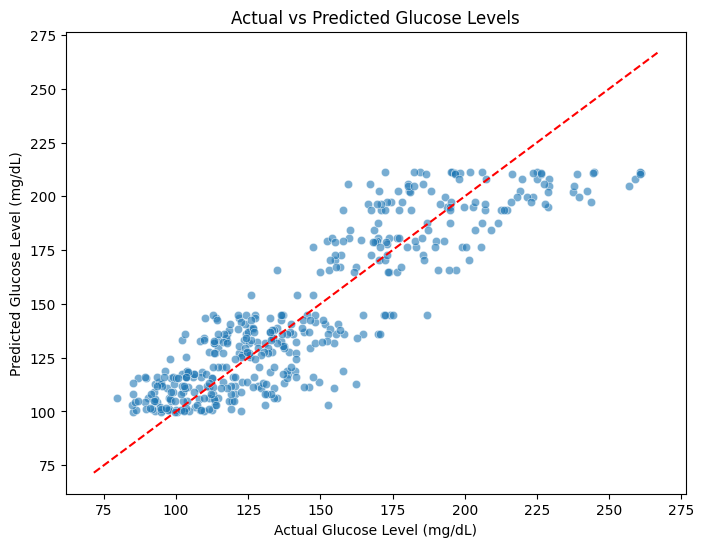

Model trained and saved as 'random_forest_model.pkl'


In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('simulated_glucose_data.csv')

# Encode categorical variables
label_encoder_sex = LabelEncoder()
df['Sex'] = label_encoder_sex.fit_transform(df['Sex'])  # Male=1, Female=0

label_encoder_category = LabelEncoder()
df['Category'] = label_encoder_category.fit_transform(df['Category'])  # Normal=0, Pre-diabetic=1, Diabetic=2

# Calculate Glycemic Load
df['Glycemic_Load'] = (df['GI'] * df['Carbs']) / 100

# Define features and target
features = ['Age', 'Sex', 'BMI', 'Fat', 'Fiber', 'Glycemic_Load', 'Category']
X = df[features]
y = df['Glucose']  # Assuming 'Glucose' is the glucose level at each timestamp

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} mg/dL")
print(f"Mean Absolute Error (MAE): {mae:.2f} mg/dL")
print(f"R² Score: {r2:.2f}")

# Plot actual vs predicted glucose levels
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Glucose Level (mg/dL)")
plt.ylabel("Predicted Glucose Level (mg/dL)")
plt.title("Actual vs Predicted Glucose Levels")
plt.show()

# Save the trained model
joblib.dump(model, 'random_forest_model.pkl')
print("Model trained and saved as 'random_forest_model.pkl'")


 Inference with Trained Random Forest Classifier

In [29]:
new_data = pd.DataFrame([{
    'Age': 50,
    'Sex': label_encoder_sex.transform(['Male'])[0],
    'BMI': 28.0,
    'Fat': 25,
    'Fiber': 7,
    'Carbs': 70,
    'GI': 65,
    'Category': label_encoder_category.transform(['Pre-diabetic'])[0]
}])

def categorize_glucose(glucose_value):
    if glucose_value < 70:
        return 'Low'
    elif 70 <= glucose_value <= 139:
        return 'Normal'
    elif 140 <= glucose_value <= 179:
        return 'Elevated'
    else:
        return 'High'

# Calculate Glycemic Load for new data
new_data['Glycemic_Load'] = (new_data['GI'] * new_data['Carbs']) / 100

# Select features for prediction
X_new = new_data[features]

# Predict glucose level
predicted_glucose = model.predict(X_new)[0]
glucose_category = categorize_glucose(predicted_glucose)
print(f"Predicted Glucose Level: {predicted_glucose:.2f} mg/dL ({glucose_category})")

Predicted Glucose Level: 138.52 mg/dL (Normal)
